# Training a Neural Network for Adaptive Cruise Control

## Intro
This notebook trains a neural network for adaptive cruise control in a highly simplified setting.

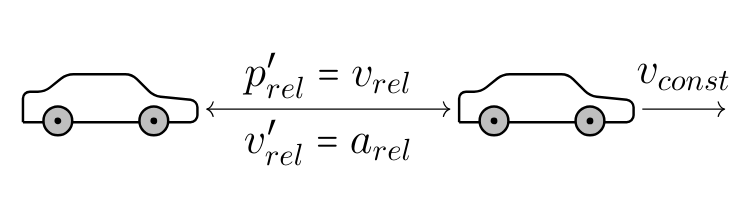

- The system is described by two variables: Relative (!) Position $p_{\text{rel}}$ and Velocity $v_{\text{rel}}$
- The Neural Network determines the acceleration of the car in the back via discrete control:
  Accelerate ($a_{\text{rel}}=-A$); No Acceleration ($a_{\text{rel}}=0$); Brake ($a_{\text{rel}}=B$)
- The dynamics of the system are given as $p_{\text{rel}}'=v_{\text{rel}},v_{\text{rel}}'=a_{\text{rel}}$ and there is a control decision at least every $0.1$ seconds
- To keep the system safe, we must ensure that the car in the back never crashes into the car in the front

## Code
We will use the reinforcement learning framework [`gymnasium`](https://gymnasium.farama.org/) (formerly OpenAI `gym`) to train our Neural Network.

### Preamble
Some necessary imports...

In [ ]:
import libs.acc
from libs.gym_helper import show_run, extract_onnx

In [ ]:
import gymnasium as gym
from gymnasium import wrappers

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
import time
import numpy as np

from torch import nn

Next, we initialize the environment.  
To see, how we can implement environments, feel free to have a look at `./libs/acc.py`

#### Digression: Reward Function
We will train our agent via Reinforcement Learning.
To this end, we require a reward function which tells our agent whether its behavior is good or not.

The computation of the reward is implemented in the `step` function of the environment in `./libs/acc.py`

Unfortunately, designing good loss functions is a very complicated topic where [lots of things can go wrong](https://par.nsf.gov/servlets/purl/10424463).  
Fortunately, in our case the reward function fell from the sky:
- If the agent is still alive and well: +0.1
- If the agent crashed: -200
- If the agent's position is larger than the cutoff ($>100$): -50

In [ ]:
# Initialize Training Environment for ACC
env = gym.make("acc-discrete-v0")

Next we initialize our neural network.  
Fortunately, we do note have to implement the NN training ourselves, but can rely on the `PPO` algorith implemented in `stable-baselines3`.
By modifying the value of `pi` in `architecture` we can modify the number of layers/nodes in the neural network that determines the agent's policy.

In [ ]:
# Initialize Agent
architecture = dict(pi=[64, 64, 64, 64], vf=[64, 64, 64, 64])
model = PPO("MlpPolicy", env, verbose=1,policy_kwargs={"activation_fn":nn.ReLU,"net_arch":architecture})

### Evaluation
Now that we have an agent, we can test the agent and see what reward we currently get.  
To this end, we setup a new evaluation environment and use the function `evaluate_policy`:

In [ ]:
# Initialize Evaluation Environment for ACC
eval_env = Monitor(gym.make('acc-discrete-v0'))

In [ ]:
# Evaluate untrained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=1000)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

We can also have a look at what the behavior of the agent looks like:

In [ ]:
show_run(eval_env, model)

Just in case, we save a copy of the untrained neural network...

In [ ]:
extract_onnx(model,"untrained_nn.onnx")

### Training
To get a better agent, we must train the model.  
This takes 5-10 minutes

In [ ]:
# Train agent
model.learn(total_timesteps=200_000)

Now we can evaluate again...

In [ ]:
# Evaluate untrained agent
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=1000)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

...and look at what the policy does...

In [ ]:
show_run(eval_env, model)

Now we save the policy neural network to use it later...

In [ ]:
extract_onnx(model,"trained_nn.onnx")